# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [Generalized Estimating Equations](#section3)




In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns
import statsmodels.formula.api as smf

from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, mean_squared_error, r2_score, ConfusionMatrixDisplay, accuracy_score,  roc_curve, auc, average_precision_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Autoregressive

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=False)

print(data.head(3))


        Date  Close/Last    Volume    Open    High     Low
0 2024-09-12      559.09  51892740  555.01  559.40  552.74
1 2024-09-11      554.42  75248610  548.70  555.36  539.96
2 2024-09-10      548.79  36394580  548.36  549.15  543.38


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Logistic regression preparation: Convert 'day_change' to binary and create a new column 'day_change_binary' (0 for Down, 1 for Up)
data['day_change_binary'] = data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Create moving averages in a separate DataFrame with the desired naming convention
moving_averages = pd.DataFrame()
for i in range(1, 51):
    ma_column_value = f'MA_{i}'
    moving_averages[ma_column_value] = data['Open'].rolling(window=i).mean()

# Create binary variables in a separate DataFrame
binary_variables = pd.DataFrame()
for i in range(1, 51):
    ma_column_value = f'MA_{i}'
    binary_column = f'open_above_MA_{i}'
    binary_variables[binary_column] = (data['Open'] > moving_averages[ma_column_value]).astype(int)

# Ensure all columns in moving_averages are numeric
moving_averages = moving_averages.apply(pd.to_numeric, errors='coerce')

# Ensure all columns in binary_variables are numeric
binary_variables = binary_variables.apply(pd.to_numeric, errors='coerce')

# Concatenate the original data, moving averages, and binary variables
data = pd.concat([data, moving_averages, binary_variables], axis=1)

# Drop rows with NaN values in the newly created columns
binary_columns_of_interest = [f'open_above_MA_{i}' for i in range(1, 51)]
data.dropna(subset=binary_columns_of_interest, inplace=True)

# Set display option to show all columns
pd.set_option('display.max_columns', None)


## <a id="section2"></a> Moving Averages: Logistic Regression


Significant Moving Averages with Coefficients > 0.6:
    Moving Average  Coefficient       P-Value  Odds Ratio  Probability  \
2                4     1.790425  3.248603e-70    5.998851     0.856881   
3                5     1.723550  2.728835e-66    5.609903     0.848499   
1                3     1.712068  1.098356e-63    5.551986     0.846920   
4                6     1.670364  2.181018e-62    5.316446     0.841584   
5                7     1.544490  1.118769e-55    4.687779     0.824073   
6                8     1.486872  3.388190e-51    4.425449     0.815561   
7                9     1.376433  1.104558e-43    3.962801     0.798367   
8               10     1.315781  1.510043e-39    3.730960     0.788393   
9               11     1.269181  7.720508e-37    3.560919     0.780521   
10              12     1.199800  5.281676e-34    3.321283     0.768436   
11              13     1.194303  4.958590e-33    3.304039     0.767429   
12              14     1.085231  1.280179e-27    2.962922 

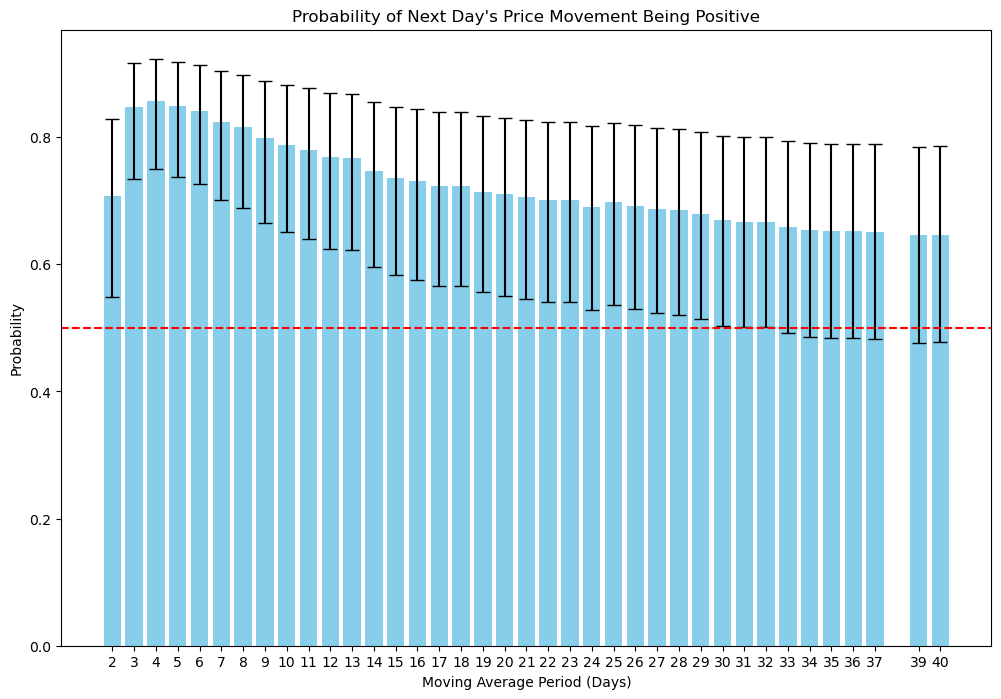


The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages... say 14 that is not included or already encapsulated in the 5 day.


You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.



In [6]:
clean_data = data.copy()

# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 2 to 50 days
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change_binary']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        fold_results = []
        
        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fit the logistic regression model using robust standard errors
            model = sm.Logit(y_train, X_train)
            result = model.fit(disp=0, cov_type='HC3')  # Use 'HC3' for robust standard errors
            
            # Predict on the test set
            y_pred = result.predict(X_test)
            
            # Calculate residuals for the test set
            residuals = y_test - y_pred
            
            # Calculate metrics for the test set
            coef = result.params[ma_column]
            p_value = result.pvalues[ma_column]
            odds_ratio = np.exp(coef)
            prob = odds_ratio / (1 + odds_ratio)
            
            fold_results.append({
                'Coefficient': coef,
                'P-Value': p_value,
                'Odds Ratio': odds_ratio,
                'Probability': prob,
                'Residuals': residuals
            })
        
        # Average the results over all folds
        avg_result = {
            'Moving Average': i,
            'Coefficient': np.mean([r['Coefficient'] for r in fold_results]),
            'P-Value': np.mean([r['P-Value'] for r in fold_results]),
            'Odds Ratio': np.mean([r['Odds Ratio'] for r in fold_results]),
            'Probability': np.mean([r['Probability'] for r in fold_results]),
            'Residuals': np.concatenate([r['Residuals'] for r in fold_results])
        }
        
        # Only collect significant results with beta > 0.6
        if avg_result['P-Value'] < 0.05 and avg_result['Coefficient'] > 0.6:
            results_list.append(avg_result)

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Calculate confidence intervals for odds ratios and probabilities
results_summary['Odds Ratio Lower Bound'] = np.exp(results_summary['Coefficient'] - 1.96 * results_summary['Coefficient'].std())
results_summary['Odds Ratio Upper Bound'] = np.exp(results_summary['Coefficient'] + 1.96 * results_summary['Coefficient'].std())
results_summary['Probability Lower Bound'] = results_summary['Odds Ratio Lower Bound'] / (1 + results_summary['Odds Ratio Lower Bound'])
results_summary['Probability Upper Bound'] = results_summary['Odds Ratio Upper Bound'] / (1 + results_summary['Odds Ratio Upper Bound'])

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the results
print("\nSignificant Moving Averages with Coefficients > 0.6:")
print(results_summary_sorted)

# Plot stacked bar graph of probabilities with confidence intervals
plt.figure(figsize=(12, 8))
plt.bar(results_summary_sorted['Moving Average'], results_summary_sorted['Probability'], yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'], results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']], capsize=5, color='skyblue')
plt.xlabel('Moving Average Period (Days)')
plt.ylabel('Probability')
plt.title("Probability of Next Day's Price Movement Being Positive")
plt.xticks(ticks=results_summary_sorted['Moving Average'], labels=results_summary_sorted['Moving Average'])
plt.axhline(y=0.5, color='red', linestyle='--')
plt.show()

print('''
The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages... say 14 that is not included or already encapsulated in the 5 day.
''')

print('''
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.
''')


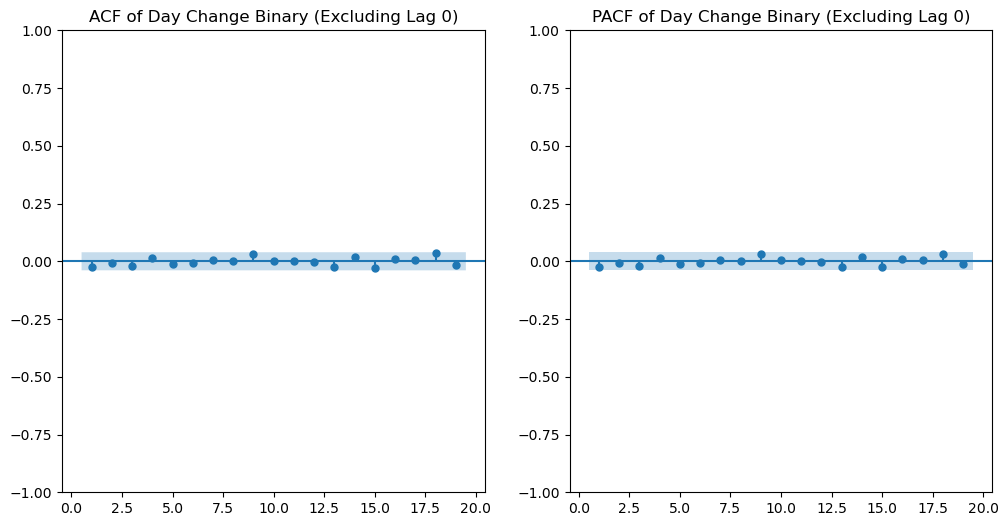

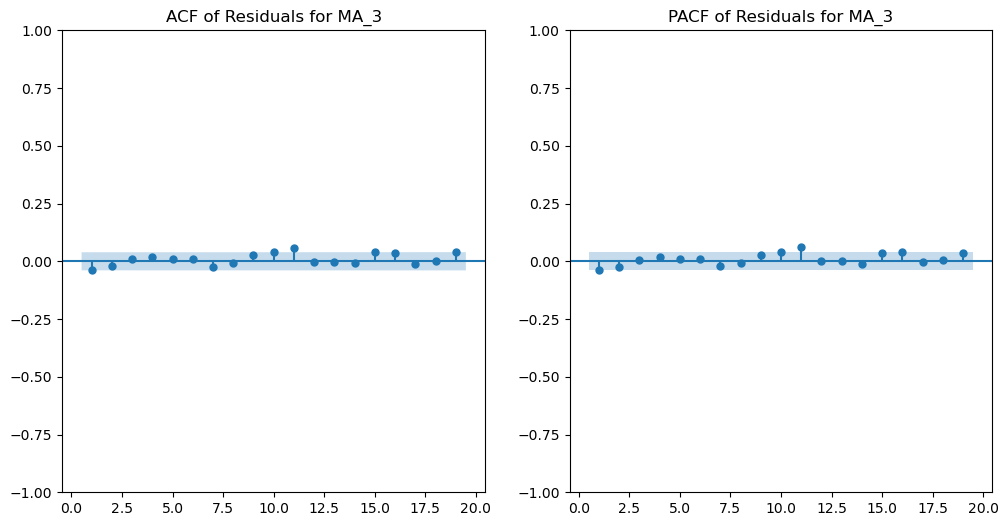

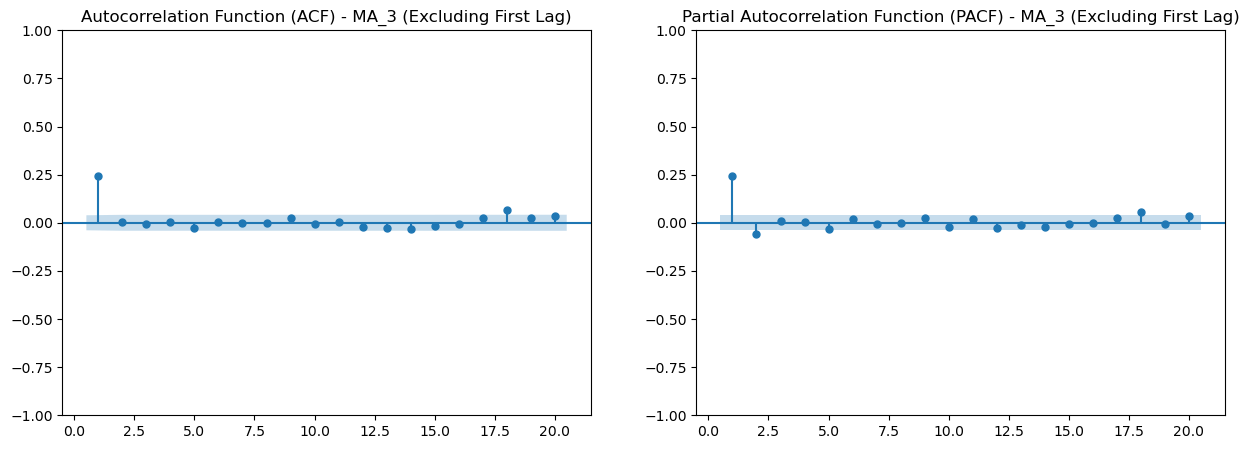


The ACF measures the correlation between the residuals at different lags. 
The PACF measures the correlation between residuals at different lags, after accounting for the correlations at shorter lags.

You're right. When dealing with moving averages, especially short-term ones like MA_3, the autocorrelation at low-level lags can 
be inherently high because the moving average is computed using overlapping data points. As a result, the values of the moving 
average at consecutive lags are highly correlated.

Absolutely! If the autocorrelations quickly fall below the significance bands at higher lags, it generally suggests that any 
remaining correlations are minimal and the residuals are more "random.




In [7]:
# Plot ACF and PACF for the 'day_change_binary' variable excluding lag 0
plt.figure(figsize=(12, 6))

# ACF plot excluding lag 0
plt.subplot(121)
plot_acf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('ACF of Day Change Binary (Excluding Lag 0)')

# PACF plot excluding lag 0
plt.subplot(122)
plot_pacf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('PACF of Day Change Binary (Excluding Lag 0)')

plt.show()



# Extract residuals for MA_4
ma_3_residuals = None
for result in results_list:
    if result['Moving Average'] == 3:
        ma_3_residuals = result['Residuals']
        break

if ma_3_residuals is not None:
    # Plot ACF and PACF for MA_3 Residuals
    plt.figure(figsize=(12, 6))

    # ACF plot for residuals of MA_3
    plt.subplot(121)
    plot_acf(ma_3_residuals, lags=19, zero=False, ax=plt.gca())
    plt.title('ACF of Residuals for MA_3')

    # PACF plot for residuals of MA_4
    plt.subplot(122)
    plot_pacf(ma_3_residuals, lags=19, zero=False, ax=plt.gca())
    plt.title('PACF of Residuals for MA_3')

    plt.show()
else:
    print("Residuals for MA_3 not found.")

    
    
# For the independent feature (ma_3) ACF and PACF plots, the code remains the same
ma_3 = data['open_above_MA_3']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(ma_3, ax=axes[0], lags=[i for i in range(1, 21)])
axes[0].set_title('Autocorrelation Function (ACF) - MA_3 (Excluding First Lag)')
plot_pacf(ma_3, ax=axes[1], lags=[i for i in range(1, 21)])
axes[1].set_title('Partial Autocorrelation Function (PACF) - MA_3 (Excluding First Lag)')
plt.show()

print('''
The ACF measures the correlation between the residuals at different lags. 
The PACF measures the correlation between residuals at different lags, after accounting for the correlations at shorter lags.

You're right. When dealing with moving averages, especially short-term ones like MA_3, the autocorrelation at low-level lags can 
be inherently high because the moving average is computed using overlapping data points. As a result, the values of the moving 
average at consecutive lags are highly correlated.

Absolutely! If the autocorrelations quickly fall below the significance bands at higher lags, it generally suggests that any 
remaining correlations are minimal and the residuals are more "random.

''')


In [8]:
ma_column = 'open_above_MA_4'  # Example predictor

# Add a log transformation of the predictor
clean_data = clean_data.assign(
    **{f'log_{ma_column}': np.log(clean_data[ma_column] + 1e-10)}
)

# Create interaction term
clean_data[f'interaction_{ma_column}'] = clean_data[ma_column] * clean_data[f'log_{ma_column}']

# Fit the logistic regression model with the interaction term and a constant term
X = sm.add_constant(clean_data[[ma_column, f'interaction_{ma_column}']])
y = clean_data['day_change_binary']
model = sm.Logit(y, X).fit(disp=0)

# Print the summary to check the significance of the interaction term
print(model.summary())


                           Logit Regression Results                           
Dep. Variable:      day_change_binary   No. Observations:                 2516
Model:                          Logit   Df Residuals:                     2514
Method:                           MLE   Df Model:                            1
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                  0.1293
Time:                        15:19:46   Log-Likelihood:                -1509.6
converged:                       True   LL-Null:                       -1733.8
Covariance Type:            nonrobust   LLR p-value:                 1.565e-99
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.9659      0.059    -16.379      0.000      -1.082      -0.850
open_above_MA_4                 1.7903        nan        nan        nan         

## <a id="section3"></a> Generalized Estimating Equations

In [9]:
# Clean data and drop rows with NaN values in the columns of interest
clean_data = data.copy()
columns_of_interest = ['day_change_binary'] + [f'open_above_MA_{i}' for i in range(2, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Reference the Original_Index column for groups
group_id = clean_data['Original_Index']

# Specify the response variable and the predictor
y = clean_data['day_change_binary']
X = clean_data[[f'open_above_MA_{i}' for i in range(2, 51)]]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Initialize the GEE model with autoregressive correlation structure
gee_model = GEE(y, X, groups=group_id, family=Binomial(), cov_struct=Autoregressive())

# Fit the model
gee_result = gee_model.fit()

# Extract coefficients and p-values
coefficients = gee_result.params
p_values = gee_result.pvalues

# Convert coefficients to probabilities
probabilities = np.exp(coefficients) / (1 + np.exp(coefficients))

# Create a summary DataFrame
results_summary = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values,
    'Probability': probabilities
})

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the sorted results
print(results_summary_sorted)


/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                  Coefficient       P-Value  Probability
open_above_MA_32     2.387504  9.057877e-02     0.915869
open_above_MA_13     1.676279  2.573471e-04     0.842411
open_above_MA_3      1.379041  1.496769e-13     0.798837
open_above_MA_37     1.269483  1.751988e-01     0.780654
open_above_MA_40     0.924281  1.780499e-01     0.715914
open_above_MA_46     0.822898  4.013530e-01     0.694851
open_above_MA_11     0.779026  4.980954e-02     0.685470
open_above_MA_45     0.686203  3.994763e-01     0.665122
open_above_MA_18     0.658202  1.942039e-01     0.658856
open_above_MA_23     0.656878  2.387547e-01     0.658559
open_above_MA_4      0.558887  5.074881e-03     0.636195
open_above_MA_6      0.539186  3.585659e-02     0.631623
open_above_MA_28     0.501532  5.005054e-01     0.622819
open_above_MA_48     0.444665  6.380168e-01     0.609370
open_above_MA_8      0.428591  1.827786e-01     0.605537
open_above_MA_25     0.423644  4.206746e-01     0.604355
open_above_MA_26     0.377723  

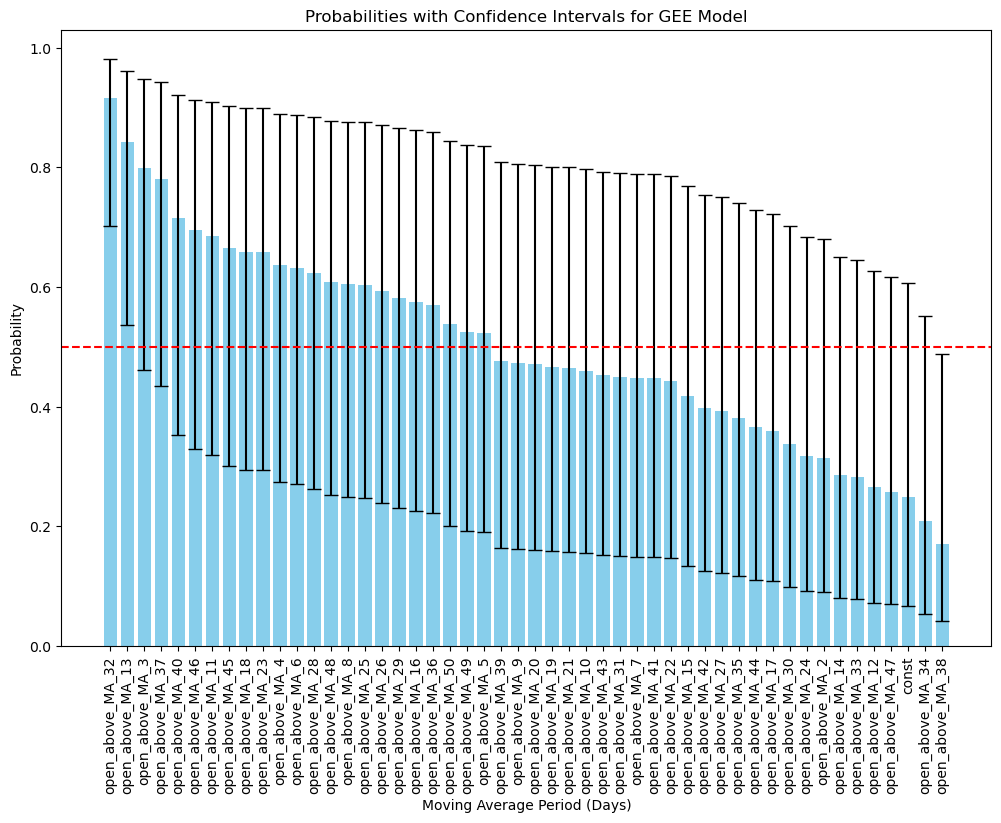


The GEE logistic regression addresses my autocorrelation concerns... 
and I use a single variable, so I don't have multicollinaerity concerns... 
and since it's a GEE logistic regression, I don't have heteroskedasticity concerns... 
leaving me with only the concern of the linearity of the logit, and the number of observations, and binary outcome.
See box-tillman test above for linearity of logit.



In [10]:

# Calculate confidence intervals for probabilities
coefficients_std = results_summary_sorted['Coefficient'].std()
results_summary_sorted['Probability Lower Bound'] = np.exp(results_summary_sorted['Coefficient'] - 1.96 * coefficients_std) / (1 + np.exp(results_summary_sorted['Coefficient'] - 1.96 * coefficients_std))
results_summary_sorted['Probability Upper Bound'] = np.exp(results_summary_sorted['Coefficient'] + 1.96 * coefficients_std) / (1 + np.exp(results_summary_sorted['Coefficient'] + 1.96 * coefficients_std))

# Plot stacked bar graph of probabilities with confidence intervals
plt.figure(figsize=(12, 8))
plt.bar(results_summary_sorted.index, results_summary_sorted['Probability'], yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'], results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']], capsize=5, color='skyblue')
plt.xlabel('Moving Average Period (Days)')
plt.ylabel('Probability')
plt.title('Probabilities with Confidence Intervals for GEE Model')
plt.xticks(ticks=results_summary_sorted.index, labels=results_summary_sorted.index, rotation=90)
plt.axhline(y=0.5, color='red', linestyle='--')
plt.show()

print('''
The GEE logistic regression addresses my autocorrelation concerns... 
and I use a single variable, so I don't have multicollinaerity concerns... 
and since it's a GEE logistic regression, I don't have heteroskedasticity concerns... 
leaving me with only the concern of the linearity of the logit, and the number of observations, and binary outcome.
See box-tillman test above for linearity of logit.
''')


In [11]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set the display width

# Extract coefficients, p-values, odds ratios, and standard errors
coefficients = gee_result.params
p_values = gee_result.pvalues
odds_ratios = np.exp(coefficients)
standard_errors = gee_result.bse  # Extract standard errors

# Create a summary DataFrame
results_summary = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values,
    'Odds Ratio': odds_ratios,
    'Standard Error': standard_errors
})

# Calculate the probability from the odds ratio
results_summary['Probability'] = results_summary['Odds Ratio'] / (1 + results_summary['Odds Ratio'])

# Filter out results with p-value above 0.05
significant_results = results_summary[results_summary['P-Value'] <= 0.05]

# Sort results by p-value for better readability
results_summary_sorted_by_pvalue = significant_results.sort_values(by='P-Value', ascending=True)

# Print the sorted results by p-value
print("\nResults sorted by p-value:")
print(results_summary_sorted_by_pvalue)



Results sorted by p-value:
                  Coefficient       P-Value  Odds Ratio  Standard Error  Probability
const               -1.100549  4.817534e-56    0.332689        0.069777     0.249637
open_above_MA_3      1.379041  1.496769e-13    3.971091        0.186674     0.798837
open_above_MA_2     -0.778025  3.478874e-07    0.459312        0.152690     0.314746
open_above_MA_13     1.676279  2.573471e-04    5.345629        0.458647     0.842411
open_above_MA_4      0.558887  5.074881e-03    1.748725        0.199443     0.636195
open_above_MA_12    -1.012422  1.799679e-02    0.363338        0.427961     0.266506
open_above_MA_6      0.539186  3.585659e-02    1.714611        0.256933     0.631623
open_above_MA_11     0.779026  4.980954e-02    2.179349        0.397139     0.685470


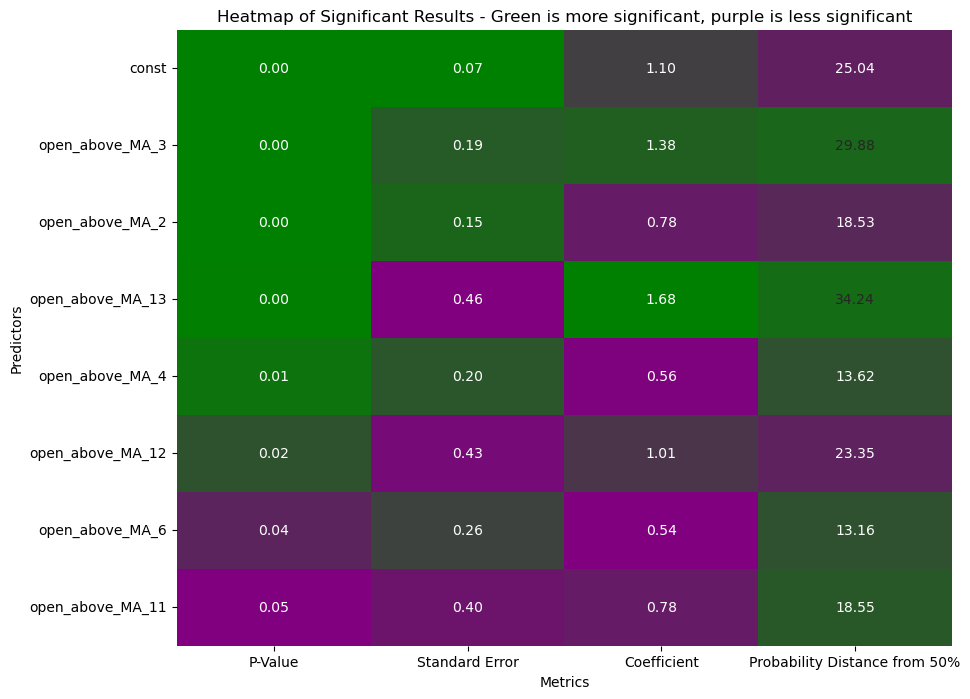


The more green the more it contributes to decision-usefulness. The more purple, the less so. The most purple box is the most 
important for any given feature.



In [12]:

# Prepare the data for the heatmap
heatmap_data = results_summary_sorted_by_pvalue[['P-Value', 'Standard Error', 'Coefficient', 'Probability']].copy()

# Calculate the Probability Distance from 50%
heatmap_data.loc[:, 'Probability Distance from 50%'] = (heatmap_data['Probability'] - 0.5).abs() * 100

# Take the absolute values for the Coefficient
heatmap_data.loc[:, 'Coefficient'] = heatmap_data['Coefficient'].abs()

# Normalize each column based on the desired "good" values
normalized_data = heatmap_data.copy()
normalized_data['P-Value'] = (heatmap_data['P-Value'] - heatmap_data['P-Value'].min()) / (heatmap_data['P-Value'].max() - heatmap_data['P-Value'].min())
normalized_data['Standard Error'] = (heatmap_data['Standard Error'] - heatmap_data['Standard Error'].min()) / (heatmap_data['Standard Error'].max() - heatmap_data['Standard Error'].min())
normalized_data['Coefficient'] = (heatmap_data['Coefficient'] - heatmap_data['Coefficient'].min()) / (heatmap_data['Coefficient'].max() - heatmap_data['Coefficient'].min())
normalized_data['Probability Distance from 50%'] = (heatmap_data['Probability Distance from 50%'] - heatmap_data['Probability Distance from 50%'].min()) / (heatmap_data['Probability Distance from 50%'].max() - heatmap_data['Probability Distance from 50%'].min())

# Define custom color maps
cmap_good = LinearSegmentedColormap.from_list('green_to_purple', ['purple', 'green'])
cmap_bad = LinearSegmentedColormap.from_list('purple_to_green', ['green', 'purple'])

# Create a matrix of colors for the heatmap
colors = normalized_data.copy()
for col in heatmap_data.columns:
    if col in ['P-Value', 'Standard Error']:
        colors[col] = normalized_data[col].apply(cmap_bad)
    else:
        colors[col] = normalized_data[col].apply(cmap_good)

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(heatmap_data.drop(columns=['Probability']), annot=True, fmt=".2f", linewidths=0.5, cbar=False)

# Apply the colors to the heatmap
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns) - 1):  # Exclude 'Probability' from loop
        heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor='none', facecolor=colors.iloc[i, j]))

# Set titles and labels
plt.title('Heatmap of Significant Results - Green is more significant, purple is less significant')
plt.xlabel('Metrics')
plt.ylabel('Predictors')

# Show the heatmap
plt.show()

print('''
The more green the more it contributes to decision-usefulness. The more purple, the less so. The most purple box is the most 
important for any given feature.
''')


In [18]:
# Create TimeSeriesSplit object for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
X = clean_data[[f'open_above_MA_3']]
y = clean_data['day_change_binary']

# Initialize lists to store results
train_scores = []
test_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Add constant term
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    
    # Fit logistic regression model
    model = sm.Logit(y_train, X_train).fit(disp=0)
    
    # Predict on training and test sets
    train_pred = model.predict(X_train) > 0.5
    test_pred = model.predict(X_test) > 0.5
    
    # Calculate accuracy
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    # Store scores
    train_scores.append(train_acc)
    test_scores.append(test_acc)

# Print average accuracy
print(f'Average training accuracy: {np.mean(train_scores)}')
print(f'Average test accuracy: {np.mean(test_scores)}')


print('''
FIX THE MODEL FITTING, YOU CAN'T FIT THE MODEL ON ALL THE OBSERVATIONS AND THEN SPLIT INTO K-FOLDS JUST FOR THE CONFIRMATION, 
THE MODEL HAS SEEN ALL THE OBSERVATIONS
''')

Average training accuracy: 0.7203782924941017
Average test accuracy: 0.6982968369829684

FIX THE MODEL FITTING, YOU CAN'T FIT THE MODEL ON ALL THE OBSERVATIONS AND THEN SPLIT INTO K-FOLDS JUST FOR THE CONFIRMATION, 
THE MODEL HAS SEEN ALL THE OBSERVATIONS

